In [1]:
import numpy as np#, pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import nltk
import os.path as osp
from nltk.util import ngrams
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data.sampler import SubsetRandomSampler
random.seed(134)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

In [2]:
train_tmp = open("hw2_data/snli_train.tsv").read().split('\n')
train_data = [row.split('\t') for row in train_tmp][1:-1]
val_tmp = open("hw2_data/snli_val.tsv").read().split('\n')
val_data = [row.split('\t') for row in val_tmp][1:-1]

In [3]:
train_s1 = [row[0] for row in train_data]
train_s2 = [row[1] for row in train_data]
val_s1 = [row[0] for row in val_data]
val_s2 = [row[1] for row in val_data]


In [4]:
train_label = [row[2] for row in train_data]
val_label = [row[2] for row in val_data]

In [5]:
#tokenize
def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
#         print(type(sample))
        tokens = nltk.word_tokenize(sample.lower())
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

# val set tokens
print ("Tokenizing val data")
val_s1_tokens, _ = tokenize_dataset(val_s1)
pkl.dump(val_s1_tokens, open("val_s1_tokens.p", "wb"))
val_s2_tokens, _ = tokenize_dataset(val_s2)
pkl.dump(val_s2_tokens, open("val_s2_tokens.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_s1_tokens, all_train_s1_tokens = tokenize_dataset(train_s1)
train_s2_tokens, all_train_s2_tokens = tokenize_dataset(train_s2)

Tokenizing val data
Tokenizing train data


In [6]:
ft_home = './'
words_to_load = 900000

with open(ft_home + 'wiki-news-300d-1M.vec','r+', encoding="utf-8") as f:
    loaded_embeddings_ft = np.zeros((2+words_to_load, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i+2, :] = np.asarray(s[1:])
        words_ft[s[0]] = i+2
        idx2words_ft[i+2] = s[0]
        ordered_words_ft.append(s[0])

In [7]:
idx2words_ft[0] = '<pad>'
idx2words_ft[1] = '<unk>'
words_ft['<pad>'] = 0
words_ft['<unk>'] = 1

In [8]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [words_ft[token] if token in words_ft else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_s1_indices = token2index_dataset(train_s1_tokens)
val_s1_indices = token2index_dataset(val_s1_tokens)
train_s2_indices = token2index_dataset(train_s2_tokens)
val_s2_indices = token2index_dataset(val_s2_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_s1_indices)))
print ("Train dataset size is {}".format(len(train_s2_indices)))
print ("Val dataset size is {}".format(len(val_s1_indices)))
print ("Val dataset size is {}".format(len(val_s2_indices)))


Train dataset size is 100000
Train dataset size is 100000
Val dataset size is 1000
Val dataset size is 1000


In [9]:
MAX_SENTENCE_LENGTH = 30
class SNLIDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, s1_data, s2_data, target_list):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.s1_data = s1_data
        self.s2_data = s2_data
        self.target_list = target_list
        assert (len(self.s1_data) == len(self.target_list))
        assert (len(self.s2_data) == len(self.target_list))
#         self.words_ft = words_ft

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        item = dict()
        
        item['s1_word_idx'] = self.s1_data[key][:MAX_SENTENCE_LENGTH]
        item['s2_word_idx'] = self.s2_data[key][:MAX_SENTENCE_LENGTH]
        item['label'] = self.target_list[key]
        return item


In [10]:
def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    s1_list, s2_list = [],[]
    label_list = []
#     length_list = []
#     print(batch)
    for datum in batch:
        label_list.append(datum['label'])
#         length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum['s1_word_idx']),
                                pad_width=((0,MAX_SENTENCE_LENGTH-len(datum['s1_word_idx']))),
                                mode="constant", constant_values=0)
        s1_list.append(list(padded_vec))
    for datum in batch:
        padded_vec = np.pad(np.array(datum['s2_word_idx']),
                                pad_width=((0,MAX_SENTENCE_LENGTH-len(datum['s2_word_idx']))),
                                mode="constant", constant_values=0)
        s2_list.append(list(padded_vec))
    label_list = [{'entailment':0,'contradiction':1,'neutral':2}[k] for k in label_list]
#     print(label_list)
    return [torch.from_numpy(np.array(s1_list)),torch.from_numpy(np.array(s2_list)), torch.LongTensor(label_list)]


In [11]:
train_loader = torch.utils.data.DataLoader(
    SNLIDataset(train_s1_indices, train_s2_indices, train_label),batch_size=BATCH_SIZE,shuffle=True,collate_fn=vocab_collate_func)

val_loader = torch.utils.data.DataLoader(
    SNLIDataset(val_s1_indices, val_s2_indices, val_label),batch_size=BATCH_SIZE,shuffle=True,collate_fn=vocab_collate_func)

In [12]:
def test_model(model, criterion=torch.nn.CrossEntropyLoss(), train=False):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    sumloss = 0 
    
    model.eval()
    # get a random minibatch
    if train:
        sp_loader = torch.utils.data.DataLoader(
            SNLIDataset(train_s1_indices, train_s2_indices, train_label),batch_size=BATCH_SIZE,collate_fn=vocab_collate_func,
            sampler=SubsetRandomSampler(range(30*BATCH_SIZE)))
    else:
        sp_loader = torch.utils.data.DataLoader(
            SNLIDataset(val_s1_indices, val_s2_indices, val_label),batch_size=BATCH_SIZE,collate_fn=vocab_collate_func,
            sampler=SubsetRandomSampler(range(30*BATCH_SIZE)))

    for sample in sp_loader:
        outputs = F.softmax(model(sample[0], sample[1]), dim=1)
        loss = criterion(outputs, sample[2])
        # nbatch += 1
        sumloss += loss.item()
        predicted = outputs.max(1, keepdim=True)[1].view(-1)
        total += len(predicted)
        truths = sample[2]
        correct += predicted.eq(truths.view_as(predicted)).sum().item()

    return (100 * correct / total), sumloss/len(sp_loader)

In [13]:
def save_checkpoint(model, name):
    #if not osp.exists(args.save_dir):
        #os.makedirs(args.save_dir)

    state = {
        "model": model.state_dict(),
#         "args": args
    }
    filename = name
    torch.save(state, osp.join(".", filename))

In [14]:
def train_model(model, learning_rate, num_epochs, savename):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    t_acc, v_acc = [], []
    t_los, v_los = [], []

    for epoch in range(num_epochs):
        for i, sample in enumerate(train_loader):
    #         print(len(sample['label']))
            model.train()
            optimizer.zero_grad()
            # Forward pass
            output = model(sample[0], sample[1])
            label = sample[2]
            loss = criterion(output, label)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 10 iterations
            if i > 0 and i % 200 == 0:
    #             validate
                val_acc, val_los = test_model(model, train=False)
                tra_acc, tra_los = test_model(model, train=True)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
                t_acc.append(tra_acc)
                v_acc.append(val_acc)
                t_los.append(tra_los)
                v_los.append(val_los)
#     save_checkpoint(model, savename)
    return t_acc, v_acc, t_los, v_los

In [15]:
class CNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers, num_classes, k=3, p=1, dropoutp=0.3):
        super().__init__()
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights_matrix))
        num_ebd, emb_size = weights_matrix.shape
        
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=k, padding=p)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=k, padding=p)
#         self.cnn3 = nn.Conv1d(emb_size, hidden_size, kernel_size=5, padding=2)
#         self.cnn4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=2)
        self.tanh = nn.Tanh()
        self.relu=nn.ReLU()  
        self.dropout = nn.Dropout(p = dropoutp)
#         self.maxpool = nn.MaxPool1d(MAX_SENTENCE_LENGTH)
#         self.linear = nn.Linear(hidden_size*2, num_classes)
        self.linear1 = nn.Linear(hidden_size*2, hidden_size*2)
        self.linear2 = nn.Linear(hidden_size*2, num_classes)
        
    def forward(self, s1, s2):
        # reset hidden state

#         batch_size = x.size()
        batch_size1, seq_len1 = s1.size()
        batch_size2, seq_len2 = s2.size()
#         print(len(s1)）

        # get embedding of characters
        s1_embed = self.embedding(s1)
        s2_embed = self.embedding(s2)
        
        hidden1 = self.conv1(s1_embed.transpose(1,2)).transpose(1,2)
        hidden2 = self.conv1(s2_embed.transpose(1,2)).transpose(1,2)
        
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, hidden1.size(1), hidden1.size(-1))
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, hidden2.size(1), hidden2.size(-1))
        
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, hidden1.size(1), hidden1.size(-1))
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, hidden2.size(1), hidden2.size(-1))
        
        hidden1 = torch.sum(hidden1, dim=1)
        hidden2 = torch.sum(hidden2, dim=1)
        
        cnn_out = torch.cat([hidden1, hidden2], 1)
        logits = self.relu(self.linear1(cnn_out))
        logits = self.dropout(logits)
        logits = self.linear2(logits)
            
        return logits

In [18]:
# output = open('cnn_h_2.pkl', 'wb')
# pickle.dump(res, output)
# output.close()

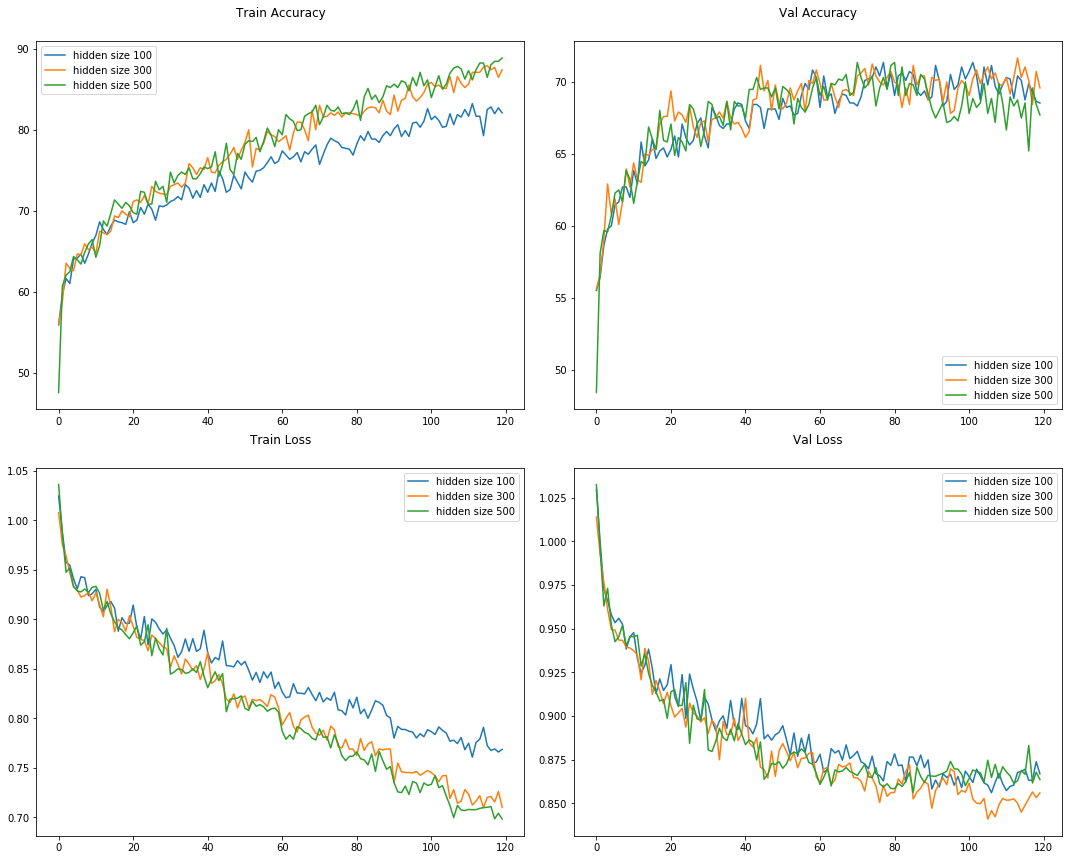

In [22]:
hidden_sizes = [100,300,500]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize= (15,12))
ax[0][0].set_title("Train Accuracy", loc="center", y=1.05)
ax[0][1].set_title("Val Accuracy", loc="center", y=1.05)
ax[1][0].set_title("Train Loss", loc="center", y=1.05)
ax[1][1].set_title("Val Loss", loc="center", y=1.05)
for i,h in enumerate(hidden_sizes):
    pkl_file = open("cnn_h_%s.pkl"%str(i), 'rb')
    res = pickle.load(pkl_file)
    pkl_file.close()
#     model = CNN(weights_matrix=loaded_embeddings_ft, hidden_size=h, num_layers=1, num_classes=3)
    t_acc, v_acc, t_los, v_los = res['t_acc'],res['v_acc'],res['t_los'],res['v_los']
#     t_acc, v_acc, t_los, v_los = train_model(model, 1e-3, 8, "cnn_h_%s.pth"%str(i+2))
    ax[0][0].plot(t_acc, label="hidden size "+str(h))
    ax[0][0].legend()
    ax[0][1].plot(v_acc, label="hidden size "+str(h))
    ax[0][1].legend()
    ax[1][0].plot(t_los, label="hidden size "+str(h))
    ax[1][0].legend()
    ax[1][1].plot(v_los, label="hidden size "+str(h)) 
    ax[1][1].legend()
plt.tight_layout()    
plt.savefig("hiddensizecnn.png")
plt.show()

Epoch: [1/8], Step: [201/3125], Validation Acc: 54.791666666666664
Epoch: [1/8], Step: [401/3125], Validation Acc: 59.270833333333336
Epoch: [1/8], Step: [601/3125], Validation Acc: 58.75
Epoch: [1/8], Step: [801/3125], Validation Acc: 57.708333333333336
Epoch: [1/8], Step: [1001/3125], Validation Acc: 58.333333333333336
Epoch: [1/8], Step: [1201/3125], Validation Acc: 61.979166666666664
Epoch: [1/8], Step: [1401/3125], Validation Acc: 59.166666666666664
Epoch: [1/8], Step: [1601/3125], Validation Acc: 61.041666666666664
Epoch: [1/8], Step: [1801/3125], Validation Acc: 61.354166666666664
Epoch: [1/8], Step: [2001/3125], Validation Acc: 62.291666666666664
Epoch: [1/8], Step: [2201/3125], Validation Acc: 64.16666666666667
Epoch: [1/8], Step: [2401/3125], Validation Acc: 63.541666666666664
Epoch: [1/8], Step: [2601/3125], Validation Acc: 63.854166666666664
Epoch: [1/8], Step: [2801/3125], Validation Acc: 62.083333333333336
Epoch: [1/8], Step: [3001/3125], Validation Acc: 63.4375
Epoch: [2

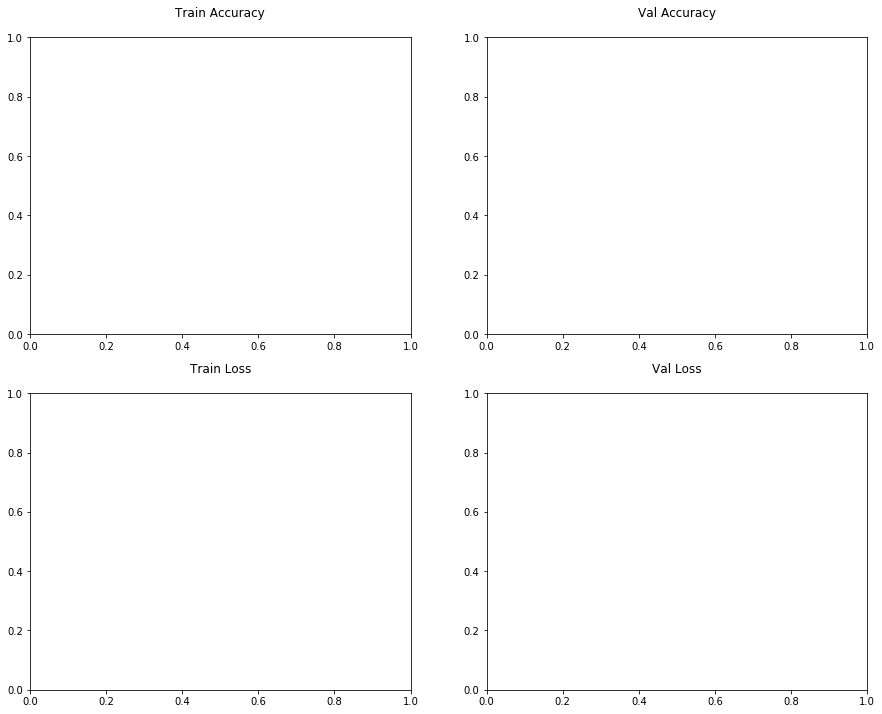

In [20]:
import pickle
ks = [5]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize= (15,12))
ax[0][0].set_title("Train Accuracy", loc="center", y=1.05)
ax[0][1].set_title("Val Accuracy", loc="center", y=1.05)
ax[1][0].set_title("Train Loss", loc="center", y=1.05)
ax[1][1].set_title("Val Loss", loc="center", y=1.05)
for i,ke in enumerate(ks):
    res = {}
    model = CNN(weights_matrix=loaded_embeddings_ft, hidden_size=300, num_layers=1, num_classes=3, k=ke, p=int((ke-1)/2))
    t_acc, v_acc, t_los, v_los = train_model(model, 1e-3, 8, "cnn_k_%s.pth"%str(i))
    res['t_acc'] = t_acc
    res['v_acc'] = v_acc
    res['t_los'] = t_los
    res['v_los'] = v_los
    output = open('cnn_k_1.pkl', 'wb')
    pickle.dump(res, output)
    output.close()
#     ax[0][0].plot(t_acc, label="kernel size "+str(h))
#     ax[0][0].legend()
#     ax[0][1].plot(v_acc, label="kernel size "+str(h))
#     ax[0][1].legend()
#     ax[1][0].plot(t_los, label="kernel size "+str(h))
#     ax[1][0].legend()
#     ax[1][1].plot(v_los, label="kernel size "+str(h)) 
#     ax[1][1].legend()
# plt.tight_layout()    
# plt.savefig("kernelcnn.png")
# plt.show()

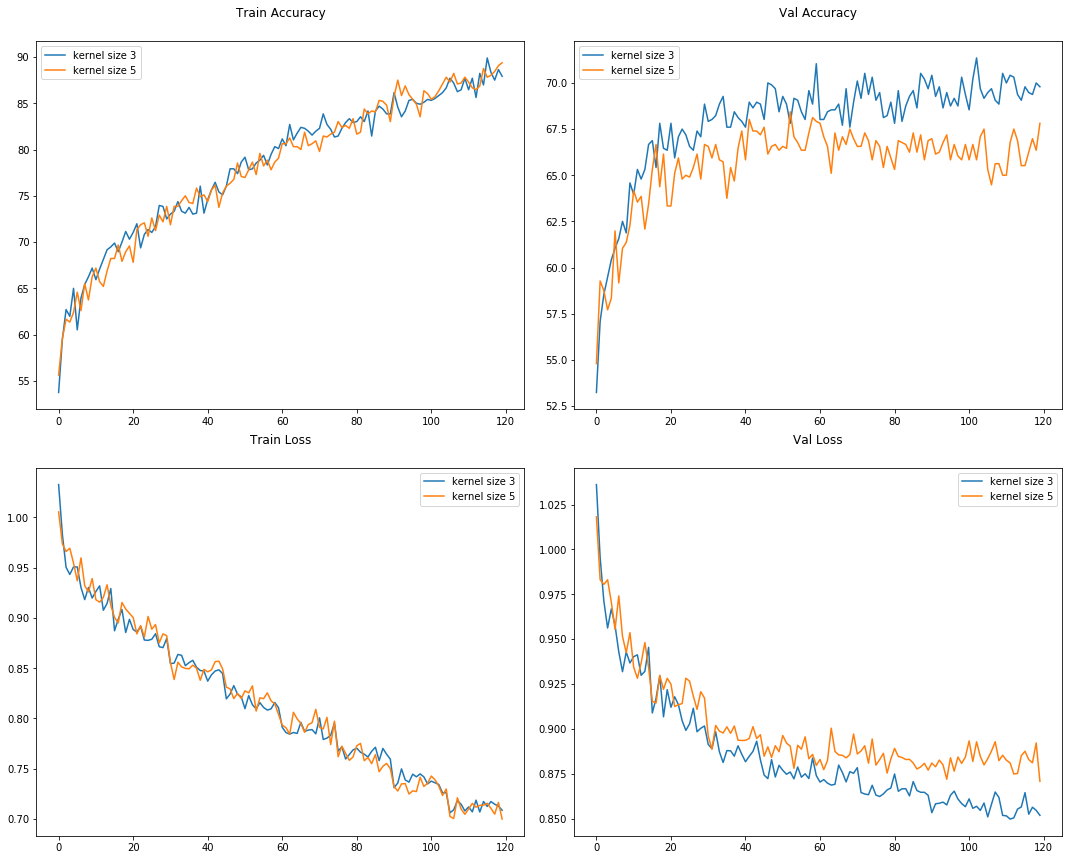

In [21]:
ks = [3,5]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize= (15,12))
ax[0][0].set_title("Train Accuracy", loc="center", y=1.05)
ax[0][1].set_title("Val Accuracy", loc="center", y=1.05)
ax[1][0].set_title("Train Loss", loc="center", y=1.05)
ax[1][1].set_title("Val Loss", loc="center", y=1.05)
for i,k in enumerate(ks):
    pkl_file = open("cnn_k_%s.pkl"%str(i), 'rb')
    res = pickle.load(pkl_file)
    pkl_file.close()
#     model = CNN(weights_matrix=loaded_embeddings_ft, hidden_size=h, num_layers=1, num_classes=3)
    t_acc, v_acc, t_los, v_los = res['t_acc'],res['v_acc'],res['t_los'],res['v_los']
#     t_acc, v_acc, t_los, v_los = train_model(model, 1e-3, 8, "cnn_h_%s.pth"%str(i+2))
    ax[0][0].plot(t_acc, label="kernel size "+str(k))
    ax[0][0].legend()
    ax[0][1].plot(v_acc, label="kernel size "+str(k))
    ax[0][1].legend()
    ax[1][0].plot(t_los, label="kernel size "+str(k))
    ax[1][0].legend()
    ax[1][1].plot(v_los, label="kernel size "+str(k)) 
    ax[1][1].legend()
plt.tight_layout()    
plt.savefig("kernelsizecnn.png")
plt.show()

In [22]:
save_checkpoint(model, 'cnn_final.pth')

### the number of trained params

In [28]:
model = CNN(weights_matrix=loaded_embeddings_ft, hidden_size=100, num_layers=1, num_classes=3)
sum(p.numel() for p in model.parameters() if p.requires_grad)

161003

In [29]:
model = CNN(weights_matrix=loaded_embeddings_ft, hidden_size=300, num_layers=1, num_classes=3)
sum(p.numel() for p in model.parameters() if p.requires_grad)

903003

In [30]:
model = CNN(weights_matrix=loaded_embeddings_ft, hidden_size=500, num_layers=1, num_classes=3)
sum(p.numel() for p in model.parameters() if p.requires_grad)

2205003

In [31]:
model = CNN(weights_matrix=loaded_embeddings_ft, hidden_size=300, num_layers=1, num_classes=3, k=5)
sum(p.numel() for p in model.parameters() if p.requires_grad)

1263003